In [ ]:
# VIT -------------------------------

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import scipy
import pandas as pd
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./fer2013/fer2013.csv')
#df.head()

x_train = []
y_train = []
x_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        x_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        x_test.append(np.array(k))
        y_test.append(row['emotion'])

x_train = np.array(x_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
x_test = np.array(x_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')
#y_train= to_categorical(y_train, num_classes=7)
#y_test = to_categorical(y_test, num_classes=7)
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)

In [3]:
x_train = np.stack((x_train,)*3, axis=4)
x_train = x_train.reshape(x_train.shape[0],48,48,3)
x_test = np.stack((x_test,)*3, axis=4)
x_test = x_test.reshape(x_test.shape[0],48,48,3)

In [4]:
#y_train = y_train.reshape(y_train.shape[0],1)
#y_test = y_test.reshape(y_test.shape[0],1)

In [4]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (28709, 48, 48, 3) - y_train shape: (28709,)
x_test shape: (3589, 48, 48, 3) - y_test shape: (3589,)


In [5]:
validation_dataset = (x_test,y_test)

In [6]:
num_classes = 7
input_shape = (48, 48, 3)

In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 500
image_size = 48  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
        #layers.RandomWidth(0.2),
        #layers.RandomHeight(0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 48 X 48
Patch size: 6 X 6
Patches per image: 64
Elements per patch: 108


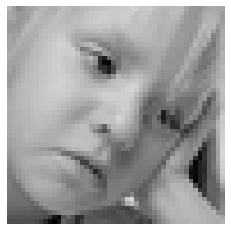

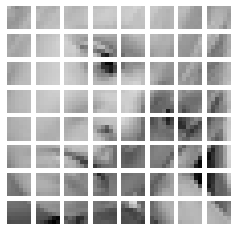

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [12]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [100]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint-vit-500epochs"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=validation_dataset,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/500
449/449 [==============================] - 74s 147ms/step - loss: 1.9485 - accuracy: 0.2401 - top-5-accuracy: 0.8728 - val_loss: 1.7179 - val_accuracy: 0.3057 - val_top-5-accuracy: 0.9161
Epoch 2/500
449/449 [==============================] - 66s 146ms/step - loss: 1.7593 - accuracy: 0.2874 - top-5-accuracy: 0.9045 - val_loss: 1.6772 - val_accuracy: 0.3285 - val_top-5-accuracy: 0.9323
Epoch 3/500
449/449 [==============================] - 65s 145ms/step - loss: 1.7174 - accuracy: 0.3134 - top-5-accuracy: 0.9144 - val_loss: 1.6174 - val_accuracy: 0.3631 - val_top-5-accuracy: 0.9348
Epoch 4/500
449/449 [==============================] - 67s 150ms/step - loss: 1.6872 - accuracy: 0.3301 - top-5-accuracy: 0.9209 - val_loss: 1.5694 - val_accuracy: 0.3904 - val_top-5-accuracy: 0.9429
Epoch 5/500
449/449 [==============================] - 68s 152ms/step - loss: 1.6558 - accuracy: 0.3448 - top-5-accuracy: 0.9290 - val_loss: 1.5480 - val_accuracy: 0.3976 - val_top-5-accuracy: 0.9471


Epoch 42/500
449/449 [==============================] - 69s 154ms/step - loss: 1.1809 - accuracy: 0.5546 - top-5-accuracy: 0.9785 - val_loss: 1.1468 - val_accuracy: 0.5670 - val_top-5-accuracy: 0.9813
Epoch 43/500
449/449 [==============================] - 68s 153ms/step - loss: 1.1681 - accuracy: 0.5616 - top-5-accuracy: 0.9790 - val_loss: 1.1655 - val_accuracy: 0.5609 - val_top-5-accuracy: 0.9763
Epoch 44/500
449/449 [==============================] - 69s 153ms/step - loss: 1.1667 - accuracy: 0.5578 - top-5-accuracy: 0.9788 - val_loss: 1.1645 - val_accuracy: 0.5684 - val_top-5-accuracy: 0.9777
Epoch 45/500
449/449 [==============================] - 69s 153ms/step - loss: 1.1627 - accuracy: 0.5604 - top-5-accuracy: 0.9789 - val_loss: 1.1535 - val_accuracy: 0.5706 - val_top-5-accuracy: 0.9811
Epoch 46/500
449/449 [==============================] - 68s 151ms/step - loss: 1.1634 - accuracy: 0.5603 - top-5-accuracy: 0.9788 - val_loss: 1.1571 - val_accuracy: 0.5701 - val_top-5-accuracy: 0.

Epoch 83/500
449/449 [==============================] - 68s 151ms/step - loss: 1.0833 - accuracy: 0.5958 - top-5-accuracy: 0.9823 - val_loss: 1.1347 - val_accuracy: 0.5762 - val_top-5-accuracy: 0.9805
Epoch 84/500
449/449 [==============================] - 68s 151ms/step - loss: 1.0843 - accuracy: 0.5966 - top-5-accuracy: 0.9824 - val_loss: 1.1259 - val_accuracy: 0.5795 - val_top-5-accuracy: 0.9797
Epoch 85/500
449/449 [==============================] - 69s 154ms/step - loss: 1.0780 - accuracy: 0.5950 - top-5-accuracy: 0.9836 - val_loss: 1.1286 - val_accuracy: 0.5904 - val_top-5-accuracy: 0.9791
Epoch 86/500
449/449 [==============================] - 66s 148ms/step - loss: 1.0821 - accuracy: 0.5934 - top-5-accuracy: 0.9823 - val_loss: 1.1161 - val_accuracy: 0.5793 - val_top-5-accuracy: 0.9808
Epoch 87/500
449/449 [==============================] - 64s 142ms/step - loss: 1.0742 - accuracy: 0.5998 - top-5-accuracy: 0.9839 - val_loss: 1.1234 - val_accuracy: 0.5784 - val_top-5-accuracy: 0.

Epoch 124/500
449/449 [==============================] - 64s 143ms/step - loss: 1.0409 - accuracy: 0.6117 - top-5-accuracy: 0.9855 - val_loss: 1.1134 - val_accuracy: 0.5907 - val_top-5-accuracy: 0.9785
Epoch 125/500
449/449 [==============================] - 65s 145ms/step - loss: 1.0489 - accuracy: 0.6069 - top-5-accuracy: 0.9845 - val_loss: 1.0988 - val_accuracy: 0.5996 - val_top-5-accuracy: 0.9774
Epoch 126/500
449/449 [==============================] - 65s 144ms/step - loss: 1.0455 - accuracy: 0.6128 - top-5-accuracy: 0.9855 - val_loss: 1.1082 - val_accuracy: 0.5926 - val_top-5-accuracy: 0.9780
Epoch 127/500
449/449 [==============================] - 64s 142ms/step - loss: 1.0495 - accuracy: 0.6099 - top-5-accuracy: 0.9846 - val_loss: 1.1070 - val_accuracy: 0.5968 - val_top-5-accuracy: 0.9799
Epoch 128/500
449/449 [==============================] - 64s 143ms/step - loss: 1.0394 - accuracy: 0.6143 - top-5-accuracy: 0.9856 - val_loss: 1.1246 - val_accuracy: 0.5860 - val_top-5-accurac

Epoch 205/500
449/449 [==============================] - 65s 145ms/step - loss: 1.0101 - accuracy: 0.6270 - top-5-accuracy: 0.9863 - val_loss: 1.0893 - val_accuracy: 0.5935 - val_top-5-accuracy: 0.9827
Epoch 206/500
449/449 [==============================] - 64s 143ms/step - loss: 1.0097 - accuracy: 0.6214 - top-5-accuracy: 0.9867 - val_loss: 1.1028 - val_accuracy: 0.5896 - val_top-5-accuracy: 0.9791
Epoch 207/500
449/449 [==============================] - 64s 143ms/step - loss: 1.0134 - accuracy: 0.6234 - top-5-accuracy: 0.9868 - val_loss: 1.1002 - val_accuracy: 0.5907 - val_top-5-accuracy: 0.9808
Epoch 208/500
449/449 [==============================] - 65s 145ms/step - loss: 1.0117 - accuracy: 0.6259 - top-5-accuracy: 0.9863 - val_loss: 1.0957 - val_accuracy: 0.6016 - val_top-5-accuracy: 0.9788
Epoch 209/500
449/449 [==============================] - 64s 142ms/step - loss: 0.9982 - accuracy: 0.6311 - top-5-accuracy: 0.9867 - val_loss: 1.0985 - val_accuracy: 0.5988 - val_top-5-accurac

Epoch 286/500
449/449 [==============================] - 65s 144ms/step - loss: 0.9922 - accuracy: 0.6339 - top-5-accuracy: 0.9872 - val_loss: 1.0876 - val_accuracy: 0.5982 - val_top-5-accuracy: 0.9822
Epoch 287/500
449/449 [==============================] - 64s 143ms/step - loss: 0.9963 - accuracy: 0.6304 - top-5-accuracy: 0.9867 - val_loss: 1.0977 - val_accuracy: 0.5957 - val_top-5-accuracy: 0.9797
Epoch 288/500
449/449 [==============================] - 65s 144ms/step - loss: 0.9957 - accuracy: 0.6321 - top-5-accuracy: 0.9879 - val_loss: 1.0912 - val_accuracy: 0.6043 - val_top-5-accuracy: 0.9780
Epoch 289/500
449/449 [==============================] - 64s 143ms/step - loss: 0.9930 - accuracy: 0.6334 - top-5-accuracy: 0.9872 - val_loss: 1.1131 - val_accuracy: 0.5968 - val_top-5-accuracy: 0.9827
Epoch 290/500
449/449 [==============================] - 67s 149ms/step - loss: 0.9942 - accuracy: 0.6336 - top-5-accuracy: 0.9875 - val_loss: 1.1112 - val_accuracy: 0.5965 - val_top-5-accurac

Epoch 367/500
449/449 [==============================] - 69s 154ms/step - loss: 0.9838 - accuracy: 0.6354 - top-5-accuracy: 0.9878 - val_loss: 1.1106 - val_accuracy: 0.5918 - val_top-5-accuracy: 0.9794
Epoch 368/500
449/449 [==============================] - 68s 152ms/step - loss: 0.9703 - accuracy: 0.6423 - top-5-accuracy: 0.9883 - val_loss: 1.1035 - val_accuracy: 0.5871 - val_top-5-accuracy: 0.9785
Epoch 369/500
449/449 [==============================] - 69s 153ms/step - loss: 0.9826 - accuracy: 0.6371 - top-5-accuracy: 0.9876 - val_loss: 1.1039 - val_accuracy: 0.5924 - val_top-5-accuracy: 0.9791
Epoch 370/500
449/449 [==============================] - 69s 154ms/step - loss: 0.9779 - accuracy: 0.6406 - top-5-accuracy: 0.9883 - val_loss: 1.1046 - val_accuracy: 0.5938 - val_top-5-accuracy: 0.9813
Epoch 371/500
449/449 [==============================] - 68s 152ms/step - loss: 0.9873 - accuracy: 0.6367 - top-5-accuracy: 0.9862 - val_loss: 1.1050 - val_accuracy: 0.5918 - val_top-5-accurac

Epoch 448/500
449/449 [==============================] - 69s 154ms/step - loss: 0.9755 - accuracy: 0.6352 - top-5-accuracy: 0.9882 - val_loss: 1.1008 - val_accuracy: 0.5910 - val_top-5-accuracy: 0.9816
Epoch 449/500
449/449 [==============================] - 69s 154ms/step - loss: 0.9802 - accuracy: 0.6353 - top-5-accuracy: 0.9873 - val_loss: 1.0977 - val_accuracy: 0.5921 - val_top-5-accuracy: 0.9797
Epoch 450/500
449/449 [==============================] - 69s 155ms/step - loss: 0.9788 - accuracy: 0.6408 - top-5-accuracy: 0.9879 - val_loss: 1.1063 - val_accuracy: 0.5907 - val_top-5-accuracy: 0.9813
Epoch 451/500
449/449 [==============================] - 68s 152ms/step - loss: 0.9812 - accuracy: 0.6396 - top-5-accuracy: 0.9870 - val_loss: 1.0983 - val_accuracy: 0.5915 - val_top-5-accuracy: 0.9816
Epoch 452/500
449/449 [==============================] - 68s 152ms/step - loss: 0.9736 - accuracy: 0.6434 - top-5-accuracy: 0.9874 - val_loss: 1.0995 - val_accuracy: 0.5963 - val_top-5-accurac

In [13]:
checkpoint_filepath = "./tmp/checkpoint-vit-500epochs"
vit_classifier = create_vit_classifier()
vit_classifier.load_weights(checkpoint_filepath)

In [18]:
y_pred = vit_classifier.predict(x_test)

113/113 [==============================] - 3s 25ms/step


In [106]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
print(matrix)

[[237   0  28  31  97  12  62]
 [ 14  21   4   2  10   0   5]
 [ 62   0 151  32 134  59  58]
 [ 30   0   9 745  44  19  48]
 [ 68   0  36  55 369   8 117]
 [ 14   0  23  25  19 315  19]
 [ 49   0  15  67 113  15 348]]


In [115]:
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral'])

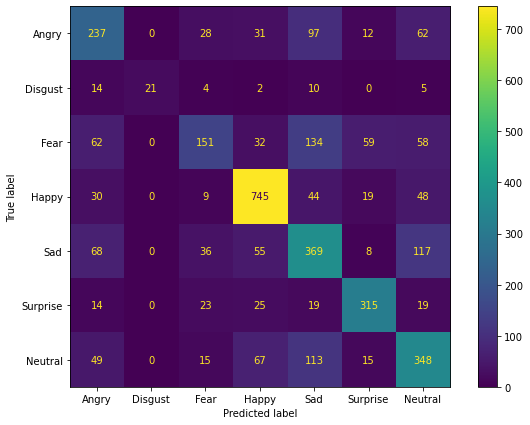

In [129]:
cm_display.plot()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

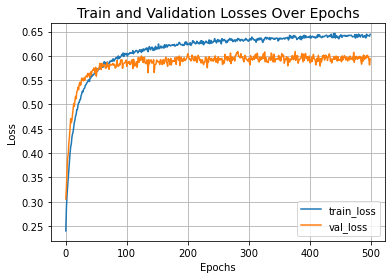

In [117]:
plt.plot(history.history["accuracy"], label="train_loss")
plt.plot(history.history['val_accuracy'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [15]:
from sklearn.metrics import classification_report

In [22]:
Y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.50      0.51      0.50       467
           1       1.00      0.38      0.55        56
           2       0.57      0.30      0.40       496
           3       0.78      0.83      0.80       895
           4       0.47      0.57      0.51       653
           5       0.74      0.76      0.75       415
           6       0.53      0.57      0.55       607

    accuracy                           0.61      3589
   macro avg       0.65      0.56      0.58      3589
weighted avg       0.61      0.61      0.60      3589

